Reducers
==============================

# Introduction
This Jupyter Notebook is part of an experiment to determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE).

# Setup
To run this notebook, you will need to set up the Google Earth Engine. Please refer to the README file in this repository for a tutorial on how to set up GEE.

# Experiment Details
The goal of this experiment is to find the temporal reducers that lead to the best performance in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- Sentinel 2 data is used as the satellite imagery.
- A time window of 1 year is chosen, covering the sampling timeframe of the labels.
- Random Forest with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

Please note that these assumptions are specific to this experiment and may differ from other experiments in this repository.

Let's proceed with the experiment!


In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

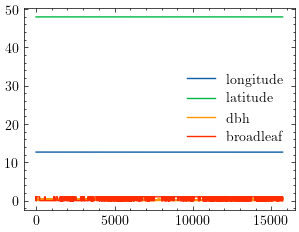

In [3]:
import pandas as pd

df = pd.read_csv("../data/processed/plot.csv")
ax = df.plot()

fig = ax.get_figure()
fig.savefig("../reports/figures/plot.svg")